# Importing Libraries

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

import tensorflow as tf

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow import keras

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.models import load_model

In [14]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Displaying Images

In [15]:
picture_size = 48
folder_path = "./dataset/"

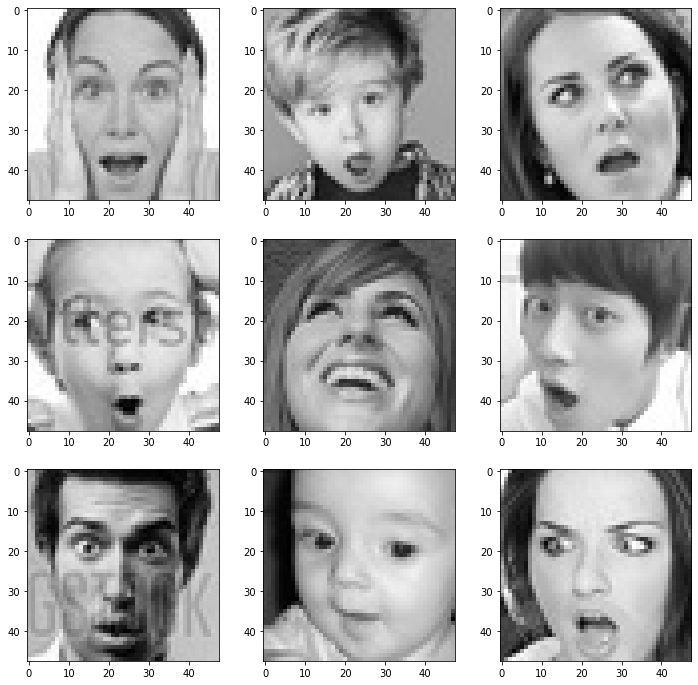

In [16]:
expression = 'surprise'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

# Making Training and Validation Data

In [17]:
batch_size  = 64

datagen_train  = ImageDataGenerator(rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))
# datagen_train  = ImageDataGenerator()

datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Model Building

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, \
     Concatenate, AvgPool2D, Dropout, Flatten, Dense

no_of_classes = 7
  
def inception_block(x, filters):
 
    t1 = Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)

    t2 = Conv2D(filters=filters[1], kernel_size=1, activation='relu')(x)
    t2 = Conv2D(filters=filters[2], kernel_size=3, padding='same', activation='relu')(t2)

    t3 = Conv2D(filters=filters[3], kernel_size=1, activation='relu')(x)
    t3 = Conv2D(filters=filters[4], kernel_size=5, padding='same', activation='relu')(t3)

    t4 = MaxPool2D(pool_size=3, strides=1, padding='same')(x)
    t4 = Conv2D(filters=filters[5], kernel_size=1, activation='relu')(t4)

    output = Concatenate()([t1, t2, t3, t4])
    return output


input = Input(shape=(48, 48, 1))
x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(input)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = Conv2D(filters=64, kernel_size=1, activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = inception_block(x, filters=[64, 96, 128, 16, 32, 32])
x = inception_block(x, filters=[128, 128, 192, 32, 96, 64])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = inception_block(x, filters=[192, 96, 208, 16, 48, 64])
x = inception_block(x, filters=[160, 112, 224, 24, 64, 64])
x = inception_block(x, filters=[128, 128, 256, 24, 64, 64])
x = inception_block(x, filters=[112, 144, 288, 32, 64, 64])
x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = inception_block(x, filters=[384, 192, 384, 48, 128, 128])
x = AvgPool2D(pool_size=7, strides=1,padding='same')(x)
x = Dropout(rate=0.4)(x)

x = Flatten()(x)
output = Dense(no_of_classes, activation='softmax')(x)

from tensorflow.keras import Model

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_114 (Conv2D)            (None, 24, 24, 64)   3200        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 12, 12, 64)  0           ['conv2d_114[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_115 (Conv2D)            (None, 12, 12, 64)   4160        ['max_pooling2d_26[0][0]'] 

                                                                                                  
 max_pooling2d_32 (MaxPooling2D  (None, 3, 3, 512)   0           ['concatenate_20[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_135 (Conv2D)            (None, 3, 3, 160)    82080       ['concatenate_20[0][0]']         
                                                                                                  
 conv2d_137 (Conv2D)            (None, 3, 3, 224)    226016      ['conv2d_136[0][0]']             
                                                                                                  
 conv2d_139 (Conv2D)            (None, 3, 3, 64)     38464       ['conv2d_138[0][0]']             
                                                                                                  
 conv2d_14

                                                                                                  
 max_pooling2d_37 (MaxPooling2D  (None, 2, 2, 832)   0           ['max_pooling2d_36[0][0]']       
 )                                                                                                
                                                                                                  
 conv2d_159 (Conv2D)            (None, 2, 2, 256)    213248      ['max_pooling2d_36[0][0]']       
                                                                                                  
 conv2d_161 (Conv2D)            (None, 2, 2, 320)    461120      ['conv2d_160[0][0]']             
                                                                                                  
 conv2d_163 (Conv2D)            (None, 2, 2, 128)    102528      ['conv2d_162[0][0]']             
                                                                                                  
 conv2d_16

# Fitting the Model with Training and Validation Data 

In [19]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model/googlenet.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=20,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint]

epochs = 150

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [20]:
history = model.fit(train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/150
448/448 [==============================] - ETA: 0s - loss: 1.8192 - accuracy: 0.2482
Epoch 1: val_accuracy improved from -inf to 0.25363, saving model to ./model\withoutaug_googlenet.h5
448/448 [==============================] - 50s 91ms/step - loss: 1.8192 - accuracy: 0.2482 - val_loss: 1.7792 - val_accuracy: 0.2536
Epoch 2/150
448/448 [==============================] - ETA: 0s - loss: 1.7443 - accuracy: 0.2823
Epoch 2: val_accuracy improved from 0.25363 to 0.32059, saving model to ./model\withoutaug_googlenet.h5
448/448 [==============================] - 39s 87ms/step - loss: 1.7443 - accuracy: 0.2823 - val_loss: 1.6830 - val_accuracy: 0.3206
Epoch 3/150
448/448 [==============================] - ETA: 0s - loss: 1.6924 - accuracy: 0.3173
Epoch 3: val_accuracy improved from 0.32059 to 0.37598, saving model to ./model\withoutaug_googlenet.h5
448/448 [==============================] - 39s 87ms/step - loss: 1.6924 - accuracy: 0.3173 - val_loss: 1.5853 - val_accuracy: 0.3760
E

448/448 [==============================] - ETA: 0s - loss: 1.2100 - accuracy: 0.5403
Epoch 27: val_accuracy improved from 0.54590 to 0.55873, saving model to ./model\withoutaug_googlenet.h5
448/448 [==============================] - 36s 81ms/step - loss: 1.2100 - accuracy: 0.5403 - val_loss: 1.1505 - val_accuracy: 0.5587
Epoch 28/150
448/448 [==============================] - ETA: 0s - loss: 1.2052 - accuracy: 0.5419
Epoch 28: val_accuracy did not improve from 0.55873
448/448 [==============================] - 38s 85ms/step - loss: 1.2052 - accuracy: 0.5419 - val_loss: 1.1695 - val_accuracy: 0.5536
Epoch 29/150
448/448 [==============================] - ETA: 0s - loss: 1.1989 - accuracy: 0.5441
Epoch 29: val_accuracy did not improve from 0.55873
448/448 [==============================] - 38s 84ms/step - loss: 1.1989 - accuracy: 0.5441 - val_loss: 1.1593 - val_accuracy: 0.5565
Epoch 30/150
448/448 [==============================] - ETA: 0s - loss: 1.1852 - accuracy: 0.5501
Epoch 30: val

448/448 [==============================] - ETA: 0s - loss: 1.0347 - accuracy: 0.6087
Epoch 54: val_accuracy did not improve from 0.59291
448/448 [==============================] - 36s 79ms/step - loss: 1.0347 - accuracy: 0.6087 - val_loss: 1.1001 - val_accuracy: 0.5918
Epoch 55/150
448/448 [==============================] - ETA: 0s - loss: 1.0333 - accuracy: 0.6087
Epoch 55: val_accuracy did not improve from 0.59291
448/448 [==============================] - 35s 77ms/step - loss: 1.0333 - accuracy: 0.6087 - val_loss: 1.1060 - val_accuracy: 0.5859
Epoch 56/150
448/448 [==============================] - ETA: 0s - loss: 1.0279 - accuracy: 0.6080
Epoch 56: val_accuracy improved from 0.59291 to 0.60170, saving model to ./model\withoutaug_googlenet.h5
448/448 [==============================] - 36s 80ms/step - loss: 1.0279 - accuracy: 0.6080 - val_loss: 1.0716 - val_accuracy: 0.6017
Epoch 57/150
448/448 [==============================] - ETA: 0s - loss: 1.0252 - accuracy: 0.6074
Epoch 57: val

448/448 [==============================] - ETA: 0s - loss: 0.8896 - accuracy: 0.6618
Epoch 82: val_accuracy did not improve from 0.61035
448/448 [==============================] - 34s 77ms/step - loss: 0.8896 - accuracy: 0.6618 - val_loss: 1.1003 - val_accuracy: 0.5995
Epoch 83/150
448/448 [==============================] - ETA: 0s - loss: 0.8817 - accuracy: 0.6627
Epoch 83: val_accuracy did not improve from 0.61035
448/448 [==============================] - 34s 77ms/step - loss: 0.8817 - accuracy: 0.6627 - val_loss: 1.0965 - val_accuracy: 0.6085
Epoch 84/150
448/448 [==============================] - ETA: 0s - loss: 0.8812 - accuracy: 0.6659
Epoch 84: val_accuracy did not improve from 0.61035
448/448 [==============================] - 35s 78ms/step - loss: 0.8812 - accuracy: 0.6659 - val_loss: 1.1148 - val_accuracy: 0.6013
Epoch 85/150
448/448 [==============================] - ETA: 0s - loss: 0.8671 - accuracy: 0.6687
Epoch 85: val_accuracy improved from 0.61035 to 0.61286, saving mo

448/448 [==============================] - 46s 103ms/step - loss: 0.7157 - accuracy: 0.7300 - val_loss: 1.2736 - val_accuracy: 0.6131
Epoch 111/150
448/448 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7253
Epoch 111: val_accuracy did not improve from 0.62012
448/448 [==============================] - 37s 82ms/step - loss: 0.7225 - accuracy: 0.7253 - val_loss: 1.2619 - val_accuracy: 0.6051
Epoch 112/150
448/448 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7302
Epoch 112: val_accuracy did not improve from 0.62012
448/448 [==============================] - 38s 86ms/step - loss: 0.7123 - accuracy: 0.7302 - val_loss: 1.2416 - val_accuracy: 0.6031
Epoch 113/150
448/448 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.7337
Epoch 113: val_accuracy did not improve from 0.62012
448/448 [==============================] - 36s 80ms/step - loss: 0.6987 - accuracy: 0.7337 - val_loss: 1.2820 - val_accuracy: 0.6084
Epoch 114/1

448/448 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.7921
Epoch 139: val_accuracy did not improve from 0.62012
448/448 [==============================] - 45s 100ms/step - loss: 0.5565 - accuracy: 0.7921 - val_loss: 1.3804 - val_accuracy: 0.5953
Epoch 140/150
448/448 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7896
Epoch 140: val_accuracy did not improve from 0.62012
448/448 [==============================] - 52s 116ms/step - loss: 0.5625 - accuracy: 0.7896 - val_loss: 1.4450 - val_accuracy: 0.6051
Epoch 141/150
448/448 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.7938
Epoch 141: val_accuracy did not improve from 0.62012
448/448 [==============================] - 46s 103ms/step - loss: 0.5489 - accuracy: 0.7938 - val_loss: 1.3692 - val_accuracy: 0.6092
Epoch 142/150
448/448 [==============================] - ETA: 0s - loss: 0.5341 - accuracy: 0.7971
Epoch 142: val_accuracy did not improve from 0.62012
448/

In [21]:
model_json = model.to_json()
with open("./model/googlenet.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./model/googlenet.h5")
print("Saved model to disk")

Saved model to disk


# Plotting Accuracy & Loss

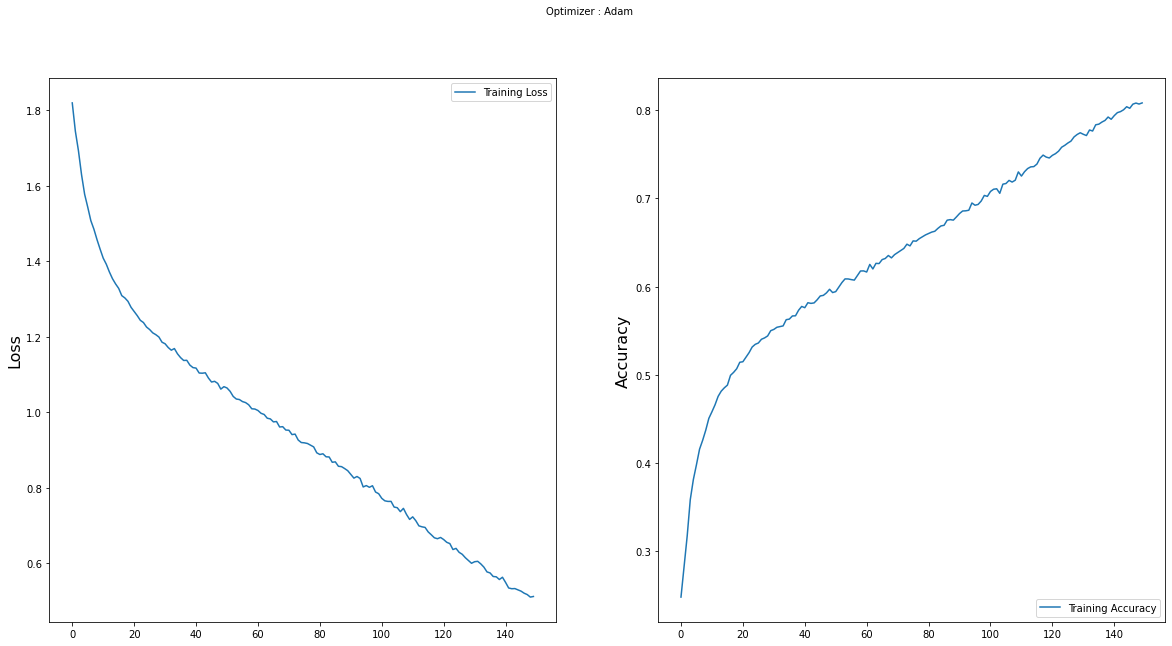

In [22]:
# plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
Y_pred = model.predict(test_set, 7178 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['angry', 'disgust', 'fear','happy','neutral','sad','surprise']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

113/113 [==============================] - 8s 59ms/step
Confusion Matrix
[[134  18 141 238 177 134 116]
 [ 12   1  16  36  21  14  11]
 [131  17 136 246 192 155 147]
 [194  29 232 425 363 296 235]
 [164  22 152 304 247 188 156]
 [161  26 195 268 243 198 156]
 [110  11 116 198 155 125 116]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.14      0.14       958
     disgust       0.01      0.01      0.01       111
        fear       0.14      0.13      0.14      1024
       happy       0.25      0.24      0.24      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.18      0.16      0.17      1247
    surprise       0.12      0.14      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178

